# PASCAL VOC

## 20 semantic classes + background

### NAS architectures based on MobileNet-v2

In [1]:
%matplotlib inline

In [2]:
import glob
import sys
sys.path.append('../../src/')
from functools import partial

In [3]:
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from nn.encoders import mbv2
from nn.micro_decoders import MicroDecoder as Decoder
from utils.helpers import prepare_img
from utils.model_zoo import load_url

In [5]:
class Segmenter(nn.Module):
    """Create Segmenter"""
    def __init__(self, encoder, decoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def _reset_clf(self, num_classes):
        self.decoder._reset_clf(num_classes)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [6]:
models_info = {
    'arch0_segm-23378522.pth' : [
        'https://cloudstor.aarnet.edu.au/plus/s/ZPXVGGgyxekvdAn/download',
        [[8, [0, 0, 5, 2], [0, 2, 8, 8], [0, 5, 1, 4]], [[3, 3], [3, 2], [3, 0]]]
    ],
    'arch1_segm-12f78b21.pth' : [
        'https://cloudstor.aarnet.edu.au/plus/s/svINhJX7IsvjCaD/download',
        [[2, [1, 0, 3, 6], [0, 1, 2, 8], [2, 0, 6, 1]], [[2, 3], [3, 1], [4, 4]]]
    ],
    'arch2_segm-8f00fc4d.pth' : [
        'https://cloudstor.aarnet.edu.au/plus/s/9b8zVuaowe6ZtAN/download',
        [[5, [0, 0, 4, 1], [3, 2, 0, 1], [5, 6, 5, 0]], [[1, 3], [4, 3], [2, 2]]]
    ]
}

In [7]:
# Configuration
AGG_SIZE = 64
AUX_CELL = False
REPEATS = 2
NUM_CLASSES = 21

In [8]:
cmap = np.load('../../src/utils/cmap.npy')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dec_fn = partial(Decoder,
                 num_classes=NUM_CLASSES,
                 agg_size=AGG_SIZE,
                 aux_cell=AUX_CELL,
                 repeats=REPEATS)
img_dir = '../imgs/VOC/'
imgs = glob.glob('{}*.jpg'.format(img_dir))

In [9]:
# Initialise models
models = dict()

for name, urlconfig in models_info.items():
    arch = name.split('-')[0]
    url, config = urlconfig
    
    enc = mbv2(pretrained=False)
    dec = dec_fn(config=config, inp_sizes=enc.out_sizes)
    segm = Segmenter(enc, dec).to(device).eval()
    segm.load_state_dict(load_url((name, url)), strict=False)
    models[arch] = segm
    del enc

/home/vladimir/Documents/venvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


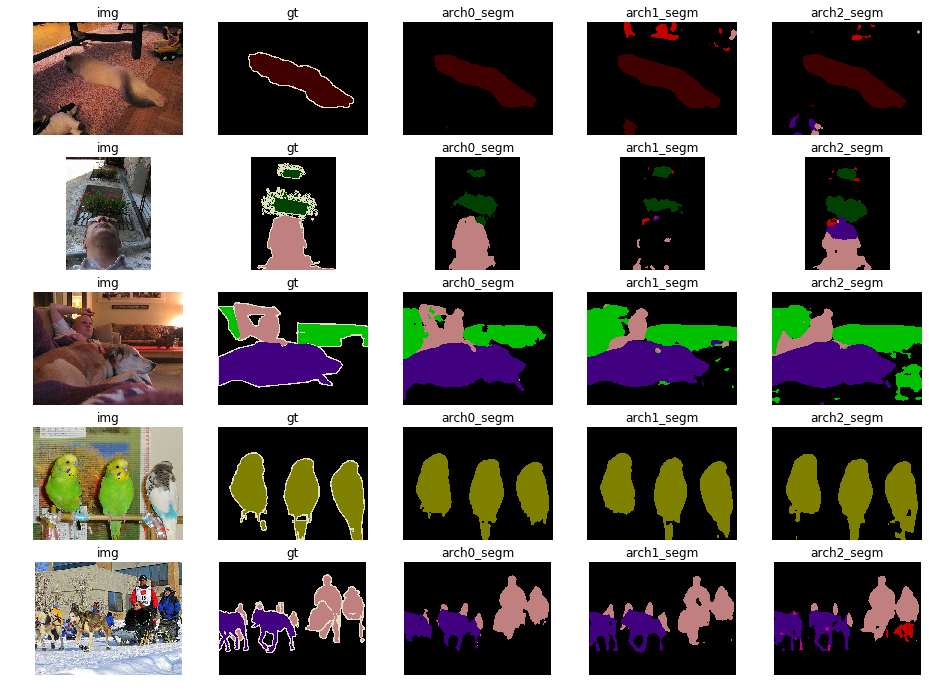

In [10]:
# Figure 7 from the paper
n_cols = len(models) + 2 # 1 - for image, 1 - for GT
n_rows = len(imgs)

plt.figure(figsize=(16, 12))
idx = 1

with torch.no_grad():
    for img_path in imgs:
        img = np.array(Image.open(img_path))
        msk = cmap[np.array(Image.open(img_path.replace('jpg', 'png')))]
        orig_size = img.shape[:2][::-1]
        
        img_inp = torch.tensor(
            prepare_img(img).transpose(2, 0, 1)[None]).float().to(device)
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.title('img')
        plt.axis('off')
        idx += 1
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(msk)
        plt.title('gt')
        plt.axis('off')
        idx += 1
        
        for mname, mnet in models.items():
            segm = mnet(img_inp)[0].squeeze().data.cpu().numpy().transpose((1, 2, 0))
            segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
            segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
            
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(segm)
            plt.title(mname)
            plt.axis('off')
            idx += 1